# Random Forest for Regression Analysis for Grocery Store

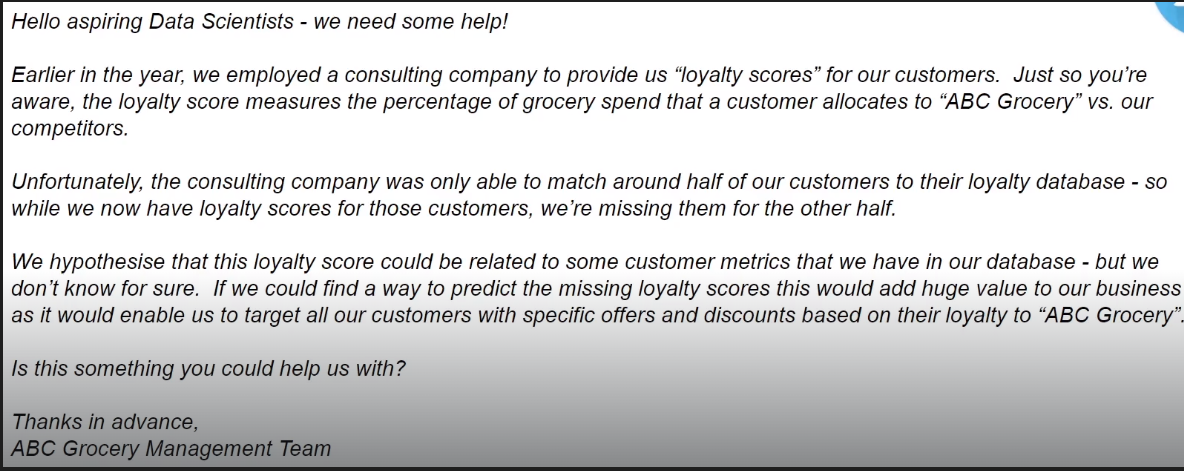

In [2]:
# import required packages
import pandas as pd
import pickle
# import required packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [4]:
# import, learning to import using pickle files
data_for_model = pickle.load(open('Saved_files/Groc_regression_modeling.p','rb'))

# we dont really need the id for the model
data_for_model.drop('customer_id', axis=1, inplace=True)
print(data_for_model.shape)
data_for_model.head()


(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [5]:
# shuffle data just in case it either came in in some order
# or we accidentally ordered it which will cause model to error
data_for_model = shuffle(data_for_model,random_state=42)
print(data_for_model.shape)
data_for_model.head()
# 8 potential input vatiables and a single output variable to predict

(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [6]:
######################################################
# deal with missing values
######################################################
data_for_model.isna().sum()
# small number of columns with missing values, lets not impute and just drop 
# but noted 

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64

In [7]:
# "any" meaning drop the whole row if any one cell is empty
data_for_model.dropna(how="any", inplace=True)
print(data_for_model.shape)
data_for_model.head()

(394, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


removig outliers for trees wont change anything so it is not necessary to run the logic on them for both random forest and tree regression

In [7]:
# ######################################################
# # deal with outliers
# ######################################################
# outlier_investigation = data_for_model.describe()
# print(outlier_investigation)
# # some outliers in distance_from_store, total_sales, total_items
# # all others did not spark any issues

In [8]:
# #boxplot approach
# outlier_columns = ["distance_from_store", "total_sales", "total_items"]
# for column in outlier_columns:
#     lower_quartile = data_for_model[column].quantile(.25)
#     upper_quartile = data_for_model[column].quantile(.75)
#     iqr= upper_quartile - lower_quartile
#     iqr_extend = iqr *2 # 1.5 reason i dont want to cut out too many outliers
#     min_border = lower_quartile - iqr_extend
#     max_border = upper_quartile + iqr_extend

#     outliers = data_for_model[(data_for_model[column]<min_border)|(data_for_model[column]>max_border)].index
#     print(f"{len(outliers)} outliers detected in column {column}")

#     data_for_model.drop(outliers,inplace=True)

# print(data_for_model.shape)
# data_for_model.head()


In [8]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model.drop(['customer_loyalty_score'], axis=1)
Y = data_for_model['customer_loyalty_score']

In [9]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(315, 8)
(79, 8)
(315,)
(79,)


In [10]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [11]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(315, 1)
(79, 1)


c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [13]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(315, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 0.04          0.67      1191.53          216   
1                 2.04          0.64      1581.41          343   
2                 2.24          0.63      1327.51          266   
3                 1.72          0.59      2094.10          352   
4                 0.24          0.53      1133.45          180   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 53                   5         22.481698       1.0  
1                 41                   4         38.570976       0.0  
2                 48                   4         27.656458       0.0  
3                 34                   3         61.591176       1.0  
4                 56                   5         20.240179       1.0  


In [14]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(79, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 2.27          0.49      1506.49          281   
1                 3.02          0.63      2401.64          278   
2                 2.72          0.57      1620.52          246   
3                 1.51          0.67      1785.67          331   
4                 1.34          0.57      1682.14          364   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 47                   3         32.052979       0.0  
1                 50                   5         48.032800       0.0  
2                 53                   5         30.575849       0.0  
3                 53                   5         33.691887       1.0  
4                 47                   4         35.790213       1.0  


below each variable is judges indenpendently 
if high input variables, doing below will help for computation and alot of input variable

In [16]:
# ######################################################
# # feature selection
# ######################################################
# regressor = LinearRegression()
# feature_selector = RFECV(regressor)

# # trains the model and assess
# fit = feature_selector.fit(x_train,y_train)
# print(fit)

In [17]:
# optimal_feature_count = feature_selector.n_features_
# print(f"optimal number features: {optimal_feature_count}")
# #it says 8 which is all of them

In [18]:
# # we didnt really need to tun this becuse it sugested 
# # all 8 columns but i ran just cause 
# x_train  = x_train.loc[:,feature_selector.get_support()]
# x_test  = x_test.loc[:,feature_selector.get_support()]
# print(x_train)
# print(x_test)

in the other approaches there was guess work where as here it cut a lot of this and able to get reliable stuff

In [19]:
# plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), 
#          fit.cv_results_['mean_test_score'], 
#          marker = "o")
# plt.ylabel("Model Score")
# plt.xlabel("Number of Features")
# plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
# plt.tight_layout()
# plt.show()

In [15]:
######################################################
# model train
######################################################
regressor = RandomForestRegressor(random_state=42)
regressor.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [16]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)

In [17]:
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.9598627943571644


In [18]:
# Cross Validation 
cv = KFold(n_splits=4,shuffle=True,random_state=42)
cv_scores =cross_val_score(regressor,x_train,y_train,cv=cv,scoring="r2")
print(cv_scores)

[0.8836017  0.93422249 0.93308669 0.94852506]


In [19]:
cv_scores.mean()

0.9248589874052471

In [20]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = x_test.shape 
print(x_test.shape) 

(79, 8)


In [21]:
adjusted_r_squared = 1-(1-r_squared)*(num_data_points-1)/(num_data_points-num_input_vars-1)
print(adjusted_r_squared) 

0.9552756851408403


feature importance! 

In [22]:
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],
                                       axis = 1)
feature_importance_summary.columns = ['input_variable', 'feature_importance']
feature_importance_summary.sort_values(by='feature_importance',inplace=True)
feature_importance_summary.head()

,input_variable,feature_importance
7,avg_basket_value,0.009975
1,gender,0.010667
6,product_area_count,0.021749
4,total_items,0.025743
5,transaction_count,0.040706


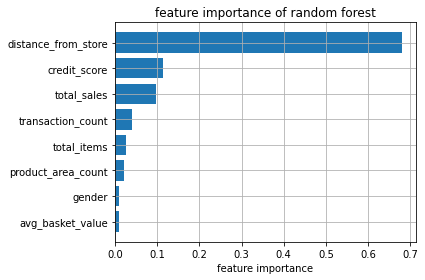

In [23]:
plt.barh(feature_importance_summary['input_variable'],feature_importance_summary['feature_importance'])
plt.title("feature importance of random forest")
plt.xlabel("feature importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

we have the feature importance, another way of calculating this out is by 

permutation importance - more advised to use 

In [24]:
result = permutation_importance(regressor, 
                                x_test, 
                                y_test, 
                                n_repeats=10,
                                random_state=42)
print(result)

{'importances_mean': array([1.45815078e+00, 1.27463198e-03, 1.18714590e-01, 1.29790448e-01,
       1.74368314e-02, 4.40707405e-02, 8.22511134e-03, 4.00298537e-03]), 'importances_std': array([0.1803007 , 0.00124786, 0.02175463, 0.00978399, 0.00387002,
       0.00931063, 0.00327316, 0.00149292]), 'importances': array([[ 1.35805446e+00,  1.33153690e+00,  1.23947045e+00,
         1.15372568e+00,  1.67458047e+00,  1.50216533e+00,
         1.70916672e+00,  1.49599713e+00,  1.44612233e+00,
         1.67068834e+00],
       [ 1.28814398e-03,  1.61237588e-03,  4.33736701e-04,
         1.63969324e-03,  5.96202645e-04,  3.81532598e-03,
        -1.27024759e-03,  1.87601088e-03,  2.02644321e-03,
         7.28634921e-04],
       [ 1.01896138e-01,  1.28003609e-01,  1.67307696e-01,
         1.20421584e-01,  1.30874769e-01,  1.03604171e-01,
         8.31711550e-02,  1.06843535e-01,  1.12764762e-01,
         1.32258481e-01],
       [ 1.17741079e-01,  1.41796746e-01,  1.29612448e-01,
         1.26334492e-

In [25]:
permutation_importance = pd.DataFrame(result['importances_mean'])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],
                                       axis = 1)
permutation_importance_summary.columns = ['input_variable', 'feature_importance']
permutation_importance_summary.sort_values(by='feature_importance',inplace=True)
permutation_importance_summary.head()

,input_variable,feature_importance
1,gender,0.001275
7,avg_basket_value,0.004003
6,product_area_count,0.008225
4,total_items,0.017437
5,transaction_count,0.044071


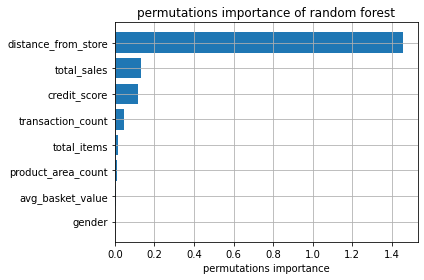

In [26]:
plt.barh(permutation_importance_summary['input_variable'],permutation_importance_summary['feature_importance'])
plt.title("permutations importance of random forest")
plt.xlabel("permutations importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

predictions under the hood

In [27]:
print(y_pred[0])

0.22624000000000016


In [36]:
new_data = [x_test.iloc[0]]
print(new_data)

[distance_from_store       2.270000
credit_score              0.490000
total_sales            1506.490000
total_items             281.000000
transaction_count        47.000000
product_area_count        3.000000
avg_basket_value         32.052979
gender_M                  0.000000
Name: 0, dtype: float64]


In [37]:
regressor.estimators_

[DecisionTreeRegressor(max_features=1.0, random_state=1608637542),
 DecisionTreeRegressor(max_features=1.0, random_state=1273642419),
 DecisionTreeRegressor(max_features=1.0, random_state=1935803228),
 DecisionTreeRegressor(max_features=1.0, random_state=787846414),
 DecisionTreeRegressor(max_features=1.0, random_state=996406378),
 DecisionTreeRegressor(max_features=1.0, random_state=1201263687),
 DecisionTreeRegressor(max_features=1.0, random_state=423734972),
 DecisionTreeRegressor(max_features=1.0, random_state=415968276),
 DecisionTreeRegressor(max_features=1.0, random_state=670094950),
 DecisionTreeRegressor(max_features=1.0, random_state=1914837113),
 DecisionTreeRegressor(max_features=1.0, random_state=669991378),
 DecisionTreeRegressor(max_features=1.0, random_state=429389014),
 DecisionTreeRegressor(max_features=1.0, random_state=249467210),
 DecisionTreeRegressor(max_features=1.0, random_state=1972458954),
 DecisionTreeRegressor(max_features=1.0, random_state=1572714583),
 De

In [41]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction = tree.predict(new_data)[0]
    predictions.append(prediction)
    tree_count += 1

print(tree_count)
print(predictions)

100
[0.201, 0.668, 0.117, 0.17, 0.203, 0.268, 0.17, 0.203, 0.23400000000000004, 0.17, 0.234, 0.12, 0.234, 0.174, 0.147, 0.352, 0.268, 0.234, 0.234, 0.234, 0.203, 0.17400000000000002, 0.17, 0.234, 0.177, 0.12, 0.314, 0.174, 0.234, 0.302, 0.352, 0.314, 0.234, 0.174, 0.116, 0.221, 0.147, 0.177, 0.203, 0.147, 0.12, 0.234, 0.234, 0.201, 0.177, 0.221, 0.203, 0.366, 0.201, 0.334, 0.366, 0.17, 0.448, 0.12, 0.234, 0.136, 0.23400000000000004, 0.17, 0.174, 0.201, 0.147, 0.201, 0.366, 0.344, 0.221, 0.17400000000000002, 0.234, 0.177, 0.17, 0.12, 0.42, 0.344, 0.12, 0.221, 0.17, 0.234, 0.17, 0.203, 0.234, 0.234, 0.314, 0.234, 0.234, 0.143, 0.17, 0.234, 0.201, 0.12, 0.174, 0.201, 0.35200000000000004, 0.234, 0.174, 0.506, 0.177, 0.352, 0.352, 0.147, 0.234, 0.201]


In [42]:
sum(predictions)/tree_count

0.22624000000000016

NOTE: the same as the y_pred, this is a look under the hood

In [ ]:
# save our files
pickle.dump(regressor,open('Saved_files/Groc_forest_reg_model.p','wb'))
pickle.dump(one_hot_encoder,open('Saved_files/Groc_forest_reg_ohe.p','wb'))